In [1]:
import os
import numpy as np
import pandas as pd
from decimal import Decimal


In [10]:
import os
import pandas as pd

base_path = r"data\LIGGGHTS\LIGGGHTS\relax_simulation_Al"

folder_names = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

file_data = []

for folder in folder_names:
    folder_path = os.path.join(base_path, folder)
    
    dump_files = [f for f in os.listdir(folder_path) if f.startswith("coord") and f.endswith(".dump")]
    input_files = [f for f in os.listdir(folder_path) if f.startswith("in.")]

    for file in dump_files:
        file_data.append([folder, file, "dump"])

    for file in input_files:
        file_data.append([folder, file, "input"])

df_files = pd.DataFrame(file_data, columns=["Folder", "File", "Type"])

df_files


,Folder,File,Type
0,relax_Al_8line_1,coordtemp0.dump,dump
1,relax_Al_8line_1,coordtemp100000.dump,dump
2,relax_Al_8line_1,coordtemp1000000.dump,dump
3,relax_Al_8line_1,coordtemp10000000.dump,dump
4,relax_Al_8line_1,coordtemp10100000.dump,dump
...,...,...,...
7315,Relax_Bed_New,coord5000000.dump,dump
7316,Relax_Bed_New,coord6000000.dump,dump
7317,Relax_Bed_New,coord7000000.dump,dump
7318,Relax_Bed_New,coord8000000.dump,dump


In [7]:
base_path = r"C:\Users\MAY02\Desktop\SLM_NeuralNetwork\Relax_Al_helix_1_1"
dump_files = sorted([f for f in os.listdir(base_path) if f.startswith("coord") and f.endswith(".dump")])

# Danh sách để lưu dữ liệu từ nhiều file
data_list = []

for dump_file in dump_files:
    file_path = os.path.join(base_path, dump_file)

    with open(file_path, "r") as file:
        lines = file.readlines()

    timestep = None
    reading_atoms = False
    atom_data = []

    for i, line in enumerate(lines):
        if "ITEM: TIMESTEP" in line:
            reading_atoms = False  # Dừng đọc dữ liệu hạt
            timestep = int(lines[i + 1].strip())  # Lấy timestep từ dòng tiếp theo
        elif "ITEM: ATOMS" in line:
            reading_atoms = True  # Bắt đầu đọc dữ liệu hạt
            headers = line.strip().split()[2:]  # Lấy tiêu đề cột (bỏ "ITEM: ATOMS")
        elif reading_atoms:
            values = line.strip().split()
            if len(values) == len(headers):  # Đảm bảo số cột khớp với tiêu đề
                atom_id = int(values[0])  # ID hạt
                atom_type = int(values[1])  # Loại hạt
                x, y, z = map(Decimal, values[2:5])  # Tọa độ chính xác cao
                temp = Decimal(values[5])  # Nhiệt độ chính xác cao

                atom_data.append([timestep, atom_id, atom_type, x, y, z, temp])

    # Chuyển danh sách thành DataFrame
    df_atoms = pd.DataFrame(atom_data, columns=["Timestep", "Atom_ID", "Type", "X", "Y", "Z", "Temperature"])
    data_list.append(df_atoms)

# Gộp toàn bộ dữ liệu từ các file
df_particles = pd.concat(data_list, ignore_index=True)

In [8]:
df_particles.sort_values(by="Timestep", inplace=True)
df_particles


,Timestep,Atom_ID,Type,X,Y,Z,Temperature
0,0,977,1,0.00102825,-0.014,0.000999993,300
3336,0,3684,1,0.080378,-0.0138648,0.00578374,300
3335,0,3303,1,0.0784315,-0.014,0.00523485,300
3334,0,3378,1,0.0765891,-0.014,0.00445689,300
3333,0,3615,1,0.0746434,-0.0137268,0.00483084,300
...,...,...,...,...,...,...,...
791663,24000000,2227,1,0.0311311,0.014,0.00723176,389.209
791662,24000000,1203,1,0.0292533,0.014,0.00654349,371.318
791661,24000000,2198,1,0.0273912,0.014,0.00727324,360.151
791668,24000000,1292,1,0.0415568,0.014,0.00665676,387.916


In [10]:
timestep_interval = 100000  # Số bước thời gian giữa mỗi lần chạy
laser_power = 1000  # Công suất laser (nhiệt độ)
omega = np.pi / 0.01  # Tần số quét laser
num_paths = 3  # Số đường quét
num_points_per_path = 20  # Số điểm trên mỗi đường quét

# Danh sách để lưu dữ liệu vị trí laser
laser_positions = []
laser_positions.append([100000, 0, 0.0105, -0.01, 0.01, 0])

# Tạo điểm nhiệt ban đầu tại timestep = 200000
laser_positions.append([200000, 0, 0.0105, -0.01, 0.01, laser_power])

# Bắt đầu quét laser
timestep = 200000  # Bắt đầu quét laser sau khi đặt nguồn nhiệt ban đầu

for i in range(1, num_paths + 1):
    for k in range(1, num_points_per_path + 1):
        timestep += timestep_interval
        y = 0.001 * k - 0.01
        x = 0.008 * np.sin(omega * y) + 0.0105 + 0.028 * (i - 1) + 0.0007 * k
        z = 0.01  # Laser luôn ở cùng độ cao
        region_id = int(f"{i}{k}")  # Tạo ID vùng từ i và k
        laser_positions.append([timestep, region_id, x, y, z, laser_power])
        
    # Quét theo chiều ngược lại (myloop2)
    for j in range(1, num_points_per_path + 1):
        timestep += timestep_interval
        y = (-1) * 0.001 * j + 0.01
        x = (-1) * 0.008 * np.sin(omega * y) + 0.0105 + 0.014 + (i - 1) * 0.028 + 0.0007 * j
        z = 0.01  # Laser luôn ở cùng độ cao
        region_id = int(f"{i}{j+300}")
        laser_positions.append([timestep, region_id, x, y, z, laser_power])


In [11]:
df_laser_positions = pd.DataFrame(laser_positions, columns=["Timestep", "Region_ID", "X", "Y", "Z", "Laser_Power"])
df_laser_positions.sort_values(by="Timestep", inplace=True)
df_laser_positions


,Timestep,Region_ID,X,Y,Z,Laser_Power
0,100000,0,0.010500,-0.010,0.01,0
1,200000,0,0.010500,-0.010,0.01,1000
2,300000,11,0.008728,-0.009,0.01,1000
3,400000,12,0.007198,-0.008,0.01,1000
4,500000,13,0.006128,-0.007,0.01,1000
...,...,...,...,...,...,...
117,11800000,3316,0.099308,-0.006,0.01,1000
118,11900000,3317,0.098872,-0.007,0.01,1000
119,12000000,3318,0.097802,-0.008,0.01,1000
120,12100000,3319,0.096272,-0.009,0.01,1000


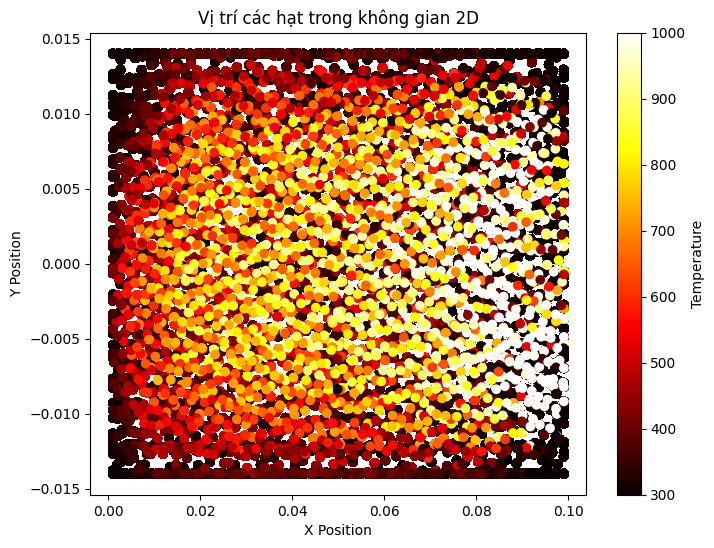

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
df_particles = df_particles.astype(float)



plt.figure(figsize=(8, 6))
sc = plt.scatter(df_particles["X"], df_particles["Y"], c=df_particles["Temperature"], cmap="hot", marker="o")

# Nhãn và tiêu đề
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Vị trí các hạt trong không gian 2D")

# Thanh màu hiển thị nhiệt độ
cbar = plt.colorbar(sc)
cbar.set_label("Temperature")

# Hiển thị biểu đồ
plt.show()


In [20]:
import numpy as np

# Giả sử chúng ta có một ngưỡng khoảng cách tối đa để xác định neighbor (tương ứng với neighbor bin 0.002)
neighbor_threshold = 0.002 

# Chọn hạt có Atom_ID = 71
target_particle = df_particles[df_particles["Atom_ID"] == 71]
if not target_particle.empty:
    x_target, y_target, z_target = target_particle.iloc[0][["X", "Y", "Z"]]

    # Find neighbors based on 3D distance
    neighbors = df_particles[(df_particles["Atom_ID"] != 71) &
                   (np.sqrt((df_particles["X"] - x_target) ** 2 +
                            (df_particles["Y"] - y_target) ** 2 )
                         < neighbor_threshold)]

unique_neighbors = neighbors.drop_duplicates(subset=["Atom_ID"])
unique_neighbors


,Timestep,Atom_ID,Type,X,Y,Z,Temperature
935,0.0,586.0,1.0,0.009039,-0.005936,0.005732,300.0
937,0.0,298.0,1.0,0.011718,-0.005247,0.005625,300.0
938,0.0,877.0,1.0,0.010733,-0.006907,0.006166,300.0
121,0.0,139.0,1.0,0.009582,-0.004517,0.001000,300.0
98,0.0,169.0,1.0,0.010972,-0.006010,0.001000,300.0
97,0.0,976.0,1.0,0.008942,-0.006494,0.001000,300.0
515,0.0,659.0,1.0,0.011108,-0.004925,0.002674,300.0
485,0.0,1328.0,1.0,0.012401,-0.005898,0.003861,300.0
484,0.0,56.0,1.0,0.009204,-0.005543,0.002739,300.0
453,0.0,455.0,1.0,0.010562,-0.007080,0.002639,300.0


In [22]:
len(unique_neighbors)

19

In [48]:
from scipy.spatial import cKDTree

# Chuyển đổi dữ liệu về kiểu float để xử lý toán học
df_particles[["X", "Y", "Z", "Temperature"]] = df_particles[["X", "Y", "Z", "Temperature"]].astype(float)

# Tạo DataFrame chứa dữ liệu laser
df_laser = pd.DataFrame(laser_positions, columns=["Timestep", "Region_ID", "Laser_X", "Laser_Y", "Laser_Z", "Laser_Power"])

# Tạo cây tìm kiếm nhanh các hạt bằng cKDTree để xác định neighbor nhanh hơn
particle_tree = cKDTree(df_particles[["X", "Y"]].values)

# Danh sách lưu dataset mới
dataset_combined = []

# Lặp qua từng timestep
for timestep in sorted(df_particles["Timestep"].unique()):
    # Lọc các hạt tại timestep hiện tại
    particles_at_timestep = df_particles[df_particles["Timestep"] == timestep].copy()
    
    # Lọc thông tin laser tại timestep hiện tại
    laser_at_timestep = df_laser[df_laser["Timestep"] == timestep]
    
    if laser_at_timestep.empty:
        continue  # Nếu không có dữ liệu laser tại timestep này, bỏ qua

    laser_x, laser_y, laser_z, laser_power = laser_at_timestep.iloc[0][["Laser_X", "Laser_Y", "Laser_Z", "Laser_Power"]]`

    # Tìm neighbor cho từng hạt
    for index, particle in particles_at_timestep.iterrows():
        atom_id, x, y, z, temperature = particle[["Atom_ID", "X", "Y", "Z", "Temperature"]]

        # Tìm neighbor trong khoảng threshold 0.002
        neighbor_indices = particle_tree.query_ball_point([x, y], neighbor_threshold)
        neighbor_temps = df_particles.iloc[neighbor_indices]["Temperature"].values if neighbor_indices else []

        # Tính toán các giá trị nhiệt độ
        max_neighbor_temp = max(neighbor_temps) if len(neighbor_temps) > 0 else None
        min_neighbor_temp = min(neighbor_temps) if len(neighbor_temps) > 0 else None
        avg_neighbor_temp = np.mean(neighbor_temps) if len(neighbor_temps) > 0 else None


        # Tìm hạt gần nhất
        if neighbor_indices:
            distances = np.linalg.norm(df_particles.iloc[neighbor_indices][["X", "Y"]].values - np.array([x, y]), axis=1)
            closest_neighbor_idx = neighbor_indices[np.argmin(distances)]
            closest_neighbor_temp = df_particles.iloc[closest_neighbor_idx]["Temperature"]
        else:
            closest_neighbor_temp = None

        # Tìm nhiệt độ tại timestep trước
        prev_timestep_temp = df_particles[(df_particles["Atom_ID"] == atom_id) & (df_particles["Timestep"] == timestep - timestep_interval)]["Temperature"]
        prev_temp = prev_timestep_temp.values[0] if not prev_timestep_temp.empty else None

        # Khoảng cách đến vị trí laser
        distance_to_laser = np.sqrt((x - laser_x) ** 2 + (y - laser_y) ** 2)

        # Thêm vào dataset mới
        dataset_combined.append([
            timestep, atom_id, x, y, z, temperature, laser_x, laser_y, laser_z, laser_power,
            max_neighbor_temp, min_neighbor_temp, avg_neighbor_temp, closest_neighbor_temp,
            prev_temp, distance_to_laser
        ])

df_combined = pd.DataFrame(dataset_combined, columns=[
    "Timestep", "Atom_ID", "X", "Y", "Z", "Temperature", "Laser_X", "Laser_Y", "Laser_Z", "Laser_Power",
    "Max_Neighbor_Temp", "Min_Neighbor_Temp", "Avg_Neighbor_Temp", "Closest_Neighbor_Temp",
    "Prev_Timestep_Temp", "Distance_To_Laser"
])

df_combined

,Timestep,Atom_ID,X,Y,Z,Temperature,Laser_X,Laser_Y,Laser_Z,Laser_Power,Max_Neighbor_Temp,Min_Neighbor_Temp,Avg_Neighbor_Temp,Closest_Neighbor_Temp,Prev_Timestep_Temp,Distance_To_Laser
0,100000.0,291.0,0.018396,-0.011196,0.001000,300.000,0.0105,-0.01,0.01,0.0,309.535,3.0,298.202993,300.008,3.00017,0.007986
1,100000.0,2501.0,0.047915,0.014000,0.011262,300.000,0.0105,-0.01,0.01,0.0,337.242,3.0,299.553417,300.000,3.00005,0.044451
2,100000.0,437.0,0.004753,-0.014000,0.001000,300.000,0.0105,-0.01,0.01,0.0,360.291,3.0,305.380448,300.000,3.00022,0.007002
3,100000.0,332.0,0.007078,-0.014000,0.001000,300.000,0.0105,-0.01,0.01,0.0,423.124,3.0,316.563851,300.000,3.00024,0.005264
4,100000.0,156.0,0.010599,-0.014000,0.001336,300.000,0.0105,-0.01,0.01,0.0,961.344,3.0,326.724178,300.036,3.00009,0.004001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609995,12200000.0,4756.0,0.097623,0.014000,0.010771,300.000,0.0945,-0.01,0.01,1000.0,300.000,3.0,297.585367,300.000,300.00000,0.024202
609996,12200000.0,4794.0,0.089003,-0.008051,0.012527,300.002,0.0945,-0.01,0.01,1000.0,300.425,3.0,297.586948,300.000,300.00100,0.005833
609997,12200000.0,4872.0,0.082928,-0.000203,0.012611,397.880,0.0945,-0.01,0.01,1000.0,992.056,3.0,317.158773,318.247,391.76600,0.015163
609998,12200000.0,4673.0,0.086084,0.013817,0.011085,303.259,0.0945,-0.01,0.01,1000.0,328.021,3.0,297.941213,300.000,302.92800,0.025260


In [50]:
df_particles["Timestep"].unique()

array([       0.,   100000.,   200000.,   300000.,   400000.,   500000.,
         600000.,   700000.,   800000.,   900000.,  1000000.,  1100000.,
        1200000.,  1300000.,  1400000.,  1500000.,  1600000.,  1700000.,
        1800000.,  1900000.,  2000000.,  2100000.,  2200000.,  2300000.,
        2400000.,  2500000.,  2600000.,  2700000.,  2800000.,  2900000.,
        3000000.,  3100000.,  3200000.,  3300000.,  3400000.,  3500000.,
        3600000.,  3700000.,  3800000.,  3900000.,  4000000.,  4100000.,
        4200000.,  4300000.,  4400000.,  4500000.,  4600000.,  4700000.,
        4800000.,  4900000.,  5000000.,  5100000.,  5200000.,  5300000.,
        5400000.,  5500000.,  5600000.,  5700000.,  5800000.,  5900000.,
        6000000.,  6100000.,  6200000.,  6300000.,  6400000.,  6500000.,
        6600000.,  6700000.,  6800000.,  6900000.,  7000000.,  7100000.,
        7200000.,  7300000.,  7400000.,  7500000.,  7600000.,  7700000.,
        7800000.,  7900000.,  8000000.,  8100000., 